In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from IPython.display import display

In [2]:
# Payload File Path & Import
base_dir = r'M:/Risk Management/DW/TUX Scorecard/'
subfile_dir = 'Thresholds/Threshold Testing/Input Files/Batch_Files_20251017/'
filename = '11012024_10152025_scoring_applicant.xlsx'

In [3]:
file_path = os.path.join(base_dir, subfile_dir, filename)

In [4]:
df = pd.read_excel(file_path)

In [5]:
# AD + Income File Path & Import
base_dir2 = r'M:/Risk Management/DW/TUX Scorecard/'
subfile_dir2 = 'Thresholds/Threshold Testing/Input Files/Batch_Files_20251017/'
filename2 = 'AppLEvel_Income_ADwith20_BatchThresholds_20251022.xlsx'

In [6]:
file_path2 = os.path.join(base_dir2, subfile_dir2, filename2)

In [7]:
df2 = pd.read_excel(file_path2)

In [8]:
print(f"Rows in Payload Data {len(df)}")

Rows in Payload Data 462345


In [9]:
print(f"Rows in AD_Income Data {len(df2)}")

Rows in AD_Income Data 944939


In [10]:
# extract debtor id from id column in df

def extract_debtorid(value):
    s = str(value)
    # remove the ' value if it exists at the front of the id string value
    if s.startswith("'"):
        s = s[1:]
    # Then extract characters 7–15
    return s[7:15]

df['DebtorID'] = df['id'].apply(extract_debtorid)

In [11]:
# Set debtor id as int

df['DebtorID'] = pd.to_numeric(df['DebtorID'], errors='coerce').astype('Int64')

In [12]:
# Extract applicant and create index for debtor/codebtor

def extract_applicant_index(value):
    s = str(value)
    # Remove the leading single quote if present
    if s.startswith("'"):
        s = s[1:]
    # Return the last character (0 or 1)
    return s[-1]

df['Applicant_Index'] = df['id'].apply(extract_applicant_index).astype('Int64')

In [13]:
# Set debtor id data type to drop .0 format

df2['DEBTOR_ID'] = df2['DEBTOR_ID'].astype(float).apply(lambda x: int(x) if pd.notna(x) else pd.NA)
df2['DEBTOR_ID'] = df2['DEBTOR_ID'].astype('Int64')


df2['CODEBTOR_ID'] = df2['CODEBTOR_ID'].astype(float).apply(lambda x: int(x) if pd.notna(x) else pd.NA)
df2['CODEBTOR_ID'] = df2['CODEBTOR_ID'].astype('Int64')

In [14]:
# Application credit profile extraction from status message when it doesn't exist in ApplicationCreditProfileType

profile = ["ThickDirty", "Thin", "ThickClean", "OpenBK"]

def extract_credit_profile(status_msg):
    if pd.isna(status_msg):
        return np.nan
    for word in profile:
        if word.lower() in status_msg.lower():
            return word
    return np.nan

# Extract profile type into a temp column
df['ExtractedProfile'] = df['StatusMessage'].apply(extract_credit_profile)

# Fill ApplicationCreditProfileType when missing
df['ApplicationCreditProfileType'] = np.where(
    df['ApplicationCreditProfileType'].isna() | (df['ApplicationCreditProfileType'].str.strip() == ''),
    df['ExtractedProfile'],
    df['ApplicationCreditProfileType']
)

In [15]:
# Drop temp column

df.drop(columns='ExtractedProfile', inplace=True)

In [16]:
print(f"Rows in Payload df before dropping remaining blank/missing credit profiles {len(df)}")

Rows in Payload df before dropping remaining blank/missing credit profiles 462345


In [17]:
print(f"Number of APPLICATION rows in Payload df before dropping remaining credit profiles {len(df[df['Applicant_Index'] == 1])}")

Number of APPLICATION rows in Payload df before dropping remaining credit profiles 392313


In [18]:
# Drop any remaining rows with no application level credit profiles 

df = df.dropna(subset=['ApplicationCreditProfileType'])

In [19]:
print(f"Rows in Payload df after dropping remaining blank/missing credit profiles {len(df)}")

Rows in Payload df after dropping remaining blank/missing credit profiles 462069


In [20]:
print(f"Number of APPLICATION rows in Payload df after dropping remaining credit profiles {len(df[df['Applicant_Index'] == 1])}")

Number of APPLICATION rows in Payload df after dropping remaining credit profiles 392167


In [21]:
# Merge payload df and ad/income df

df3 = df.merge(df2, how='left', left_on='AccountId', right_on='ACCOUNT_ID')

In [22]:
# Drop unnecessary columns

# df3.drop(columns=['id', 'RequestId', 'RowId', 'SourceFileName', 'ErrorMessage', 'CreditScorecardVersion', 
#                         'CapacityScorecardVersion', 'ACCOUNT_ID.1'], inplace=True)

df3.drop(columns=['id', 'RequestId', 'RowId', 'SourceFileName', 'ErrorMessage', 'CreditScorecardVersion', 
                        'CapacityScorecardVersion'], inplace=True)

In [23]:
print(f"Rows in merged df {len(df3)}")

Rows in merged df 462069


In [24]:
print(f"Number of Debtor Application rows in final df after merging {len(df3[df3['Applicant_Index'] == 1])}")

print(f"Number of Co-Debtor Application rows in final df after merging {len(df3[df3['Applicant_Index'] == 0])}")

Number of Debtor Application rows in final df after merging 392167
Number of Co-Debtor Application rows in final df after merging 69902


In [25]:
# Debtor/Codebtor mix

print(f"Number of DEBTOR Application rows: {(len(df3[df3['Applicant_Index'] == 1]) / len(df3)):.2%}")

print(f"Number of Co-DEBTOR Application rows: {(len(df3[df3['Applicant_Index'] == 0]) / len(df3)):.2%}")

Number of DEBTOR Application rows: 84.87%
Number of Co-DEBTOR Application rows: 15.13%


In [26]:
# with pd.ExcelWriter('M:/Risk Management/DW/TUX Scorecard/Thresholds/Threshold Testing/BatchFile_Thresholds_20251020/test.xlsx', engine='xlsxwriter') as writer:
#     df3.to_excel(writer, sheet_name='Sheet1', index=False)

### Auto Decline Rules Impact

In [27]:
# Filter to applicant only rows 
applicants = df3[df3['Applicant_Index'] == 1]

# Total # of applicants by credit profile
total_by_profile = applicants.groupby('ApplicationCreditProfileType').size().reset_index(name='Total_Applicants')

# Number of auto-declines by profile
auto_declines_by_profile = applicants[
    (applicants['HITAUTODECLINE_NO14_168'] == 1)
    ].groupby('ApplicationCreditProfileType').size().reset_index(name='AutoDecline_Count')

# combine totals
profile_summary = total_by_profile.merge(auto_declines_by_profile, on='ApplicationCreditProfileType', how='left')

# Backfill any nans with 0
profile_summary['AutoDecline_Count'] = profile_summary['AutoDecline_Count'].fillna(0).astype(int)

# calc %
profile_summary['AutoDecline_Pct'] = profile_summary['AutoDecline_Count'] / profile_summary['Total_Applicants']

# calc remaining apps
profile_summary['Remaining_Applications'] = profile_summary['Total_Applicants'] - profile_summary['AutoDecline_Count']
profile_summary['Remaining_Pct'] = profile_summary['Remaining_Applications'] / profile_summary['Total_Applicants']

# Add totals
total_row = pd.DataFrame({
    'ApplicationCreditProfileType': ['Total'],
    'Total_Applicants': [profile_summary['Total_Applicants'].sum()],
    'AutoDecline_Count': [profile_summary['AutoDecline_Count'].sum()],
    'Remaining_Applications': [profile_summary['Remaining_Applications'].sum()],
})

# calc weighted average %
total_auto_pct = (profile_summary['AutoDecline_Count'].sum() / profile_summary['Total_Applicants'].sum())
total_remain_pct = (profile_summary['Remaining_Applications'].sum() / profile_summary['Total_Applicants'].sum())

total_row['AutoDecline_Pct'] = total_auto_pct
total_row['Remaining_Pct'] = total_remain_pct

# Append total row back on
profile_summary = pd.concat([profile_summary, total_row], ignore_index=True)

# Clean up output
profile_summary['Total_Applicants'] = profile_summary['Total_Applicants'].map('{:,}'.format)
profile_summary['AutoDecline_Count'] = profile_summary['AutoDecline_Count'].map('{:,}'.format)
profile_summary['Remaining_Applications'] = profile_summary['Remaining_Applications'].map('{:,}'.format)
profile_summary['AutoDecline_Pct'] = profile_summary['AutoDecline_Pct'].apply(lambda x: f"{x:.2%}")
profile_summary['Remaining_Pct'] = profile_summary['Remaining_Pct'].apply(lambda x: f"{x:.2%}")

# Sort descending by AutoDecline_Pct
profile_summary_display = pd.concat([
    profile_summary[profile_summary['ApplicationCreditProfileType'] != 'Total'].sort_values(
        'AutoDecline_Pct', ascending=False),
    profile_summary[profile_summary['ApplicationCreditProfileType'] == 'Total']
], ignore_index=True)

# print
display(profile_summary_display)


,ApplicationCreditProfileType,Total_Applicants,AutoDecline_Count,AutoDecline_Pct,Remaining_Applications,Remaining_Pct
0,Unscoreable,"3,499","3,489",99.71%,10,0.29%
1,Thin,"134,104","68,442",51.04%,"65,662",48.96%
2,ThickDirty,"168,513","79,183",46.99%,"89,330",53.01%
3,ThickClean,"52,366","14,771",28.21%,"37,595",71.79%
4,OpenBK,"33,685","5,044",14.97%,"28,641",85.03%
5,Total,"392,167","170,929",43.59%,"221,238",56.41%


In [28]:
# # Filter to applicant only rows 
# applicants = df3[df3['Applicant_Index'] == 1]

# # Total # of apps by credit profile
# total_by_profile = applicants.groupby('ApplicationCreditProfileType').size().reset_index(name='Total_Applicants')

# # Number of auto-declines by profile
# auto_declines_by_profile = applicants[
#     (applicants['HITAUTODECLINE_NO14_168'] == 1)
#     # & (applicants['DECLINED_COUNT'] == 1)
#     & (applicants['APPROVED_COUNT'] == 0)
# ].groupby('ApplicationCreditProfileType').size().reset_index(name='AutoDecline_Count')

# # Combine totals
# profile_summary = total_by_profile.merge(auto_declines_by_profile, on='ApplicationCreditProfileType', how='left')

# # Backfill any nan values with 0
# profile_summary['AutoDecline_Count'] = profile_summary['AutoDecline_Count'].fillna(0).astype(int)

# # calc %
# profile_summary['AutoDecline_Pct'] = profile_summary['AutoDecline_Count'] / profile_summary['Total_Applicants']

# # Calc remaining apps
# profile_summary['Remaining_Applications'] = profile_summary['Total_Applicants'] - profile_summary['AutoDecline_Count']
# profile_summary['Remaining_Pct'] = profile_summary['Remaining_Applications'] / profile_summary['Total_Applicants']

# # Add totals row
# total_row = pd.DataFrame({
#     'ApplicationCreditProfileType': ['Total'],
#     'Total_Applicants': [profile_summary['Total_Applicants'].sum()],
#     'AutoDecline_Count': [profile_summary['AutoDecline_Count'].sum()],
#     'Remaining_Applications': [profile_summary['Remaining_Applications'].sum()],
# })

# # calc weighted average %
# total_auto_pct = (profile_summary['AutoDecline_Count'].sum() / profile_summary['Total_Applicants'].sum())
# total_remain_pct = (profile_summary['Remaining_Applications'].sum() / profile_summary['Total_Applicants'].sum())

# total_row['AutoDecline_Pct'] = total_auto_pct
# total_row['Remaining_Pct'] = total_remain_pct

# # Add total row on
# profile_summary = pd.concat([profile_summary, total_row], ignore_index=True)

# # clean up numbers for table
# profile_summary['Total_Applicants'] = profile_summary['Total_Applicants'].map('{:,}'.format)
# profile_summary['AutoDecline_Count'] = profile_summary['AutoDecline_Count'].map('{:,}'.format)
# profile_summary['Remaining_Applications'] = profile_summary['Remaining_Applications'].map('{:,}'.format)
# profile_summary['AutoDecline_Pct'] = profile_summary['AutoDecline_Pct'].apply(lambda x: f"{x:.2%}")
# profile_summary['Remaining_Pct'] = profile_summary['Remaining_Pct'].apply(lambda x: f"{x:.2%}")

# # Sort descending by AutoDecline_Pct 
# profile_summary_display = pd.concat([
#     profile_summary[profile_summary['ApplicationCreditProfileType'] != 'Total'].sort_values(
#         'AutoDecline_Pct', ascending=False),
#     profile_summary[profile_summary['ApplicationCreditProfileType'] == 'Total']
# ], ignore_index=True)

# # print
# display(profile_summary_display)


#### Pre Credit Declines

In [29]:
# # Filter to applicant rows 
# applicants = df3[df3['Applicant_Index'] == 1]

# # Total # of applicants by profile
# total_by_profile = applicants.groupby('ApplicationCreditProfileType').size().reset_index(name='Total_Applicants')

# # Number of auto-declines by profile
# auto_declines_by_profile = applicants[
#     (applicants['BITPRECREDIT'] == 1)
#     ].groupby('ApplicationCreditProfileType').size().reset_index(name='PreCredit_Decline_Count')

# # Merge totals and filtered counts
# profile_summary = total_by_profile.merge(auto_declines_by_profile, on='ApplicationCreditProfileType', how='left')

# # Fill NaN counts with 0
# profile_summary['PreCredit_Decline_Count'] = profile_summary['PreCredit_Decline_Count'].fillna(0).astype(int)

# # Calculate percentages
# profile_summary['PreCredit_Decline_Pct'] = profile_summary['PreCredit_Decline_Count'] / profile_summary['Total_Applicants']

# # Calculate remaining applications
# profile_summary['Remaining_Applications'] = profile_summary['Total_Applicants'] - profile_summary['PreCredit_Decline_Count']
# profile_summary['Remaining_Pct'] = profile_summary['Remaining_Applications'] / profile_summary['Total_Applicants']

# # Add Total row
# total_row = pd.DataFrame({
#     'ApplicationCreditProfileType': ['Total'],
#     'Total_Applicants': [profile_summary['Total_Applicants'].sum()],
#     'PreCredit_Decline_Count': [profile_summary['PreCredit_Decline_Count'].sum()],
#     'Remaining_Applications': [profile_summary['Remaining_Applications'].sum()],
# })

# # Compute weighted average percentages
# total_auto_pct = (profile_summary['PreCredit_Decline_Count'].sum() / profile_summary['Total_Applicants'].sum())
# total_remain_pct = (profile_summary['Remaining_Applications'].sum() / profile_summary['Total_Applicants'].sum())

# total_row['PreCredit_Decline_Pct'] = total_auto_pct
# total_row['Remaining_Pct'] = total_remain_pct

# # Append total row
# profile_summary = pd.concat([profile_summary, total_row], ignore_index=True)

# # Beautify numbers for display
# profile_summary['Total_Applicants'] = profile_summary['Total_Applicants'].map('{:,}'.format)
# profile_summary['PreCredit_Decline_Count'] = profile_summary['PreCredit_Decline_Count'].map('{:,}'.format)
# profile_summary['Remaining_Applications'] = profile_summary['Remaining_Applications'].map('{:,}'.format)
# profile_summary['PreCredit_Decline_Pct'] = profile_summary['PreCredit_Decline_Pct'].apply(lambda x: f"{x:.2%}")
# profile_summary['Remaining_Pct'] = profile_summary['Remaining_Pct'].apply(lambda x: f"{x:.2%}")

# # Sort descending by AutoDecline_Pct (excluding Total row)
# profile_summary_display = pd.concat([
#     profile_summary[profile_summary['ApplicationCreditProfileType'] != 'Total'].sort_values(
#         'PreCredit_Decline_Pct', ascending=False),
#     profile_summary[profile_summary['ApplicationCreditProfileType'] == 'Total']
# ], ignore_index=True)

# # Display nicely
# display(profile_summary_display)


In [30]:
# # Filter to applicant rows
# applicants = df3[df3['Applicant_Index'] == 1]

# # Total # of applicants by profile
# total_by_profile = applicants.groupby('ApplicationCreditProfileType').size().reset_index(name='Total_Applicants')

# # Number of pre-credit declines by profile
# precredit_declines = applicants[applicants['BITPRECREDIT'] == 1]
# precredit_by_profile = precredit_declines.groupby('ApplicationCreditProfileType').size().reset_index(name='PreCredit_Decline_Count')

# # Number of declines due to income <3000 ONLY for those NOT hitting pre-credit rules
# income_declines = applicants[
#     (applicants['BITPRECREDIT'] != 1) & (applicants['COMBINCOME'] < 3000)
# ]
# income_by_profile = income_declines.groupby('ApplicationCreditProfileType').size().reset_index(name='Income_Decline_Count')

# # Merge totals with both decline counts
# profile_summary = total_by_profile.merge(precredit_by_profile, on='ApplicationCreditProfileType', how='left')
# profile_summary = profile_summary.merge(income_by_profile, on='ApplicationCreditProfileType', how='left')

# # Fill NaNs with 0
# profile_summary['PreCredit_Decline_Count'] = profile_summary['PreCredit_Decline_Count'].fillna(0).astype(int)
# profile_summary['Income_Decline_Count'] = profile_summary['Income_Decline_Count'].fillna(0).astype(int)

# # Total pre credit declines (pre-credit rules + income)
# profile_summary['Total_Decline_Count'] = profile_summary['PreCredit_Decline_Count'] + profile_summary['Income_Decline_Count']

# # %
# profile_summary['PreCredit_Decline_Pct'] = profile_summary['PreCredit_Decline_Count'] / profile_summary['Total_Applicants']
# profile_summary['Income_Decline_Pct'] = profile_summary['Income_Decline_Count'] / profile_summary['Total_Applicants']
# profile_summary['Total_Decline_Pct'] = profile_summary['Total_Decline_Count'] / profile_summary['Total_Applicants']

# # Remaining apps
# profile_summary['Remaining_Applications'] = profile_summary['Total_Applicants'] - profile_summary['Total_Decline_Count']
# profile_summary['Remaining_Pct'] = profile_summary['Remaining_Applications'] / profile_summary['Total_Applicants']

# # Add totals
# total_row = pd.DataFrame({
#     'ApplicationCreditProfileType': ['Total'],
#     'Total_Applicants': [profile_summary['Total_Applicants'].sum()],
#     'PreCredit_Decline_Count': [profile_summary['PreCredit_Decline_Count'].sum()],
#     'Income_Decline_Count': [profile_summary['Income_Decline_Count'].sum()],
#     'Total_Decline_Count': [profile_summary['Total_Decline_Count'].sum()],
#     'PreCredit_Decline_Pct': [profile_summary['PreCredit_Decline_Count'].sum() / profile_summary['Total_Applicants'].sum()],
#     'Income_Decline_Pct': [profile_summary['Income_Decline_Count'].sum() / profile_summary['Total_Applicants'].sum()],
#     'Total_Decline_Pct': [profile_summary['Total_Decline_Count'].sum() / profile_summary['Total_Applicants'].sum()],
#     'Remaining_Applications': [profile_summary['Remaining_Applications'].sum()],
#     'Remaining_Pct': [profile_summary['Remaining_Applications'].sum() / profile_summary['Total_Applicants'].sum()]
# })

# # Add totals row onto table
# profile_summary = pd.concat([profile_summary, total_row], ignore_index=True)

# # Clean up numbers in table
# for col in ['Total_Applicants', 'PreCredit_Decline_Count', 'Income_Decline_Count', 'Total_Decline_Count', 'Remaining_Applications']:
#     profile_summary[col] = profile_summary[col].map('{:,}'.format)

# for col in ['PreCredit_Decline_Pct', 'Income_Decline_Pct', 'Total_Decline_Pct', 'Remaining_Pct']:
#     profile_summary[col] = profile_summary[col].apply(lambda x: f"{x:.2%}")

# # Sort by Total_Decline_Pct descending
# profile_summary_display = pd.concat([
#     profile_summary[profile_summary['ApplicationCreditProfileType'] != 'Total'].sort_values(
#         'Total_Decline_Pct', ascending=False),
#     profile_summary[profile_summary['ApplicationCreditProfileType'] == 'Total']
# ], ignore_index=True)

# # print table
# display(profile_summary_display)


#### Post Credit Declines

In [31]:
ct_postcredit_declines = (df3['BITPOSTCREDIT_NO14_168'] == 1).sum()
print(f"Number of rows hitting post-credit auto decline rules: {ct_postcredit_declines}")

Number of rows hitting post-credit auto decline rules: 201256


In [32]:
# Filter to applicant rows 
applicants = df3[df3['Applicant_Index'] == 1]

# Total # of applicants by profile
total_by_profile = applicants.groupby('ApplicationCreditProfileType').size().reset_index(name='Total_Applicants')

# Number of auto-declines by profile
auto_declines_by_profile = applicants[
    (applicants['BITPOSTCREDIT_NO14_168'] == 1)
    ].groupby('ApplicationCreditProfileType').size().reset_index(name='PostCredit_Decline_Count')

# Merge totals and filtered counts
profile_summary = total_by_profile.merge(auto_declines_by_profile, on='ApplicationCreditProfileType', how='left')

# Fill NaN counts with 0
profile_summary['PostCredit_Decline_Count'] = profile_summary['PostCredit_Decline_Count'].fillna(0).astype(int)

# Calculate percentages
profile_summary['PostCredit_Decline_Pct'] = profile_summary['PostCredit_Decline_Count'] / profile_summary['Total_Applicants']

# Calculate remaining applications
profile_summary['Remaining_Applications'] = profile_summary['Total_Applicants'] - profile_summary['PostCredit_Decline_Count']
profile_summary['Remaining_Pct'] = profile_summary['Remaining_Applications'] / profile_summary['Total_Applicants']

# Add Total row
total_row = pd.DataFrame({
    'ApplicationCreditProfileType': ['Total'],
    'Total_Applicants': [profile_summary['Total_Applicants'].sum()],
    'PostCredit_Decline_Count': [profile_summary['PostCredit_Decline_Count'].sum()],
    'Remaining_Applications': [profile_summary['Remaining_Applications'].sum()],
})

# Compute weighted average percentages
total_auto_pct = (profile_summary['PostCredit_Decline_Count'].sum() / profile_summary['Total_Applicants'].sum())
total_remain_pct = (profile_summary['Remaining_Applications'].sum() / profile_summary['Total_Applicants'].sum())

total_row['PostCredit_Decline_Pct'] = total_auto_pct
total_row['Remaining_Pct'] = total_remain_pct

# Append total row
profile_summary = pd.concat([profile_summary, total_row], ignore_index=True)

# Beautify numbers for display
profile_summary['Total_Applicants'] = profile_summary['Total_Applicants'].map('{:,}'.format)
profile_summary['PostCredit_Decline_Count'] = profile_summary['PostCredit_Decline_Count'].map('{:,}'.format)
profile_summary['Remaining_Applications'] = profile_summary['Remaining_Applications'].map('{:,}'.format)
profile_summary['PostCredit_Decline_Pct'] = profile_summary['PostCredit_Decline_Pct'].apply(lambda x: f"{x:.2%}")
profile_summary['Remaining_Pct'] = profile_summary['Remaining_Pct'].apply(lambda x: f"{x:.2%}")

# Sort descending by AutoDecline_Pct (excluding Total row)
profile_summary_display = pd.concat([
    profile_summary[profile_summary['ApplicationCreditProfileType'] != 'Total'].sort_values(
        'PostCredit_Decline_Pct', ascending=False),
    profile_summary[profile_summary['ApplicationCreditProfileType'] == 'Total']
], ignore_index=True)

# Display nicely
display(profile_summary_display)


,ApplicationCreditProfileType,Total_Applicants,PostCredit_Decline_Count,PostCredit_Decline_Pct,Remaining_Applications,Remaining_Pct
0,Unscoreable,"3,499","3,486",99.63%,13,0.37%
1,Thin,"134,104","66,314",49.45%,"67,790",50.55%
2,ThickDirty,"168,513","77,259",45.85%,"91,254",54.15%
3,ThickClean,"52,366","13,262",25.33%,"39,104",74.67%
4,OpenBK,"33,685","3,982",11.82%,"29,703",88.18%
5,Total,"392,167","164,303",41.90%,"227,864",58.10%


### Minimum Income

In [33]:
# ct_below_3k = (df3['COMBINCOME'] < 3000).sum()
# print(f"Number of rows below minimum income: {ct_below_3k}")

In [34]:
# pct_below_3k = ct_below_3k / len(df3) * 100
# print(f"Percent of rows below minimum income: {pct_below_3k:.2f}%")

In [35]:
# df3 = df3[df3['COMBINCOME'] >= 3000]

In [36]:
# row_count = len(df3)
# print(f"Rows after removing minimum income: {row_count}")

In [37]:
# # Filter to applicant rows
# applicants = df3[df3['Applicant_Index'] == 1]

# # Total # of applicants by profile
# total_by_profile = (
#     applicants.groupby('ApplicationCreditProfileType')
#     .size()
#     .reset_index(name='Total_Applicants')
# )

# # --- Stage 1: Pre-credit rule declines ---
# precredit_declines = applicants[applicants['BITPRECREDIT'] == 1]
# precredit_by_profile = (
#     precredit_declines.groupby('ApplicationCreditProfileType')
#     .size()
#     .reset_index(name='PreCredit_Decline_Count')
# )

# # --- Stage 2: Low income declines (<3000) ---
# income_declines = applicants[
#     (applicants['BITPRECREDIT'] != 1) &
#     (applicants['COMBINCOME'] < 3000)
# ]
# income_by_profile = (
#     income_declines.groupby('ApplicationCreditProfileType')
#     .size()
#     .reset_index(name='Income_Decline_Count')
# )

# # --- Stage 3: Auto-decline rule (AD_20 == 1) ---
# auto_declines = applicants[
#     (applicants['BITPRECREDIT'] != 1) &
#     (applicants['COMBINCOME'] >= 3000) &
#     (applicants['AD_20'] == 1)
# ]
# auto_by_profile = (
#     auto_declines.groupby('ApplicationCreditProfileType')
#     .size()
#     .reset_index(name='AutoDecline_Count')
# )

# # Merge all decline counts
# profile_summary = total_by_profile
# profile_summary = profile_summary.merge(precredit_by_profile, on='ApplicationCreditProfileType', how='left')
# profile_summary = profile_summary.merge(income_by_profile, on='ApplicationCreditProfileType', how='left')
# profile_summary = profile_summary.merge(auto_by_profile, on='ApplicationCreditProfileType', how='left')

# # Fill NaNs with 0 and enforce int
# for col in ['PreCredit_Decline_Count', 'Income_Decline_Count', 'AutoDecline_Count']:
#     profile_summary[col] = profile_summary[col].fillna(0).astype(int)

# # --- Combined decline metrics ---
# profile_summary['Total_Decline_Count'] = (
#     profile_summary['PreCredit_Decline_Count']
#     + profile_summary['Income_Decline_Count']
#     + profile_summary['AutoDecline_Count']
# )
# profile_summary['Remaining_Applications'] = (
#     profile_summary['Total_Applicants'] - profile_summary['Total_Decline_Count']
# )

# # --- Percentages ---
# for num_col, pct_col in [
#     ('PreCredit_Decline_Count', 'PreCredit_Decline_Pct'),
#     ('Income_Decline_Count', 'Income_Decline_Pct'),
#     ('AutoDecline_Count', 'AutoDecline_Pct'),
#     ('Total_Decline_Count', 'Total_Decline_Pct'),
#     ('Remaining_Applications', 'Remaining_Pct'),
# ]:
#     profile_summary[pct_col] = profile_summary[num_col] / profile_summary['Total_Applicants']

# # --- Add Total row ---
# total_row = pd.DataFrame({
#     'ApplicationCreditProfileType': ['Total'],
#     'Total_Applicants': [profile_summary['Total_Applicants'].sum()],
#     'PreCredit_Decline_Count': [profile_summary['PreCredit_Decline_Count'].sum()],
#     'Income_Decline_Count': [profile_summary['Income_Decline_Count'].sum()],
#     'AutoDecline_Count': [profile_summary['AutoDecline_Count'].sum()],
#     'Total_Decline_Count': [profile_summary['Total_Decline_Count'].sum()],
#     'Remaining_Applications': [profile_summary['Remaining_Applications'].sum()],
# })

# # Weighted averages for total row
# for pct_col in ['PreCredit_Decline_Pct', 'Income_Decline_Pct', 'AutoDecline_Pct', 'Total_Decline_Pct', 'Remaining_Pct']:
#     count_col = pct_col.replace('_Pct', '_Count').replace('Remaining_Count', 'Remaining_Applications')
#     total_row[pct_col] = [
#         profile_summary[count_col].sum() / profile_summary['Total_Applicants'].sum()
#     ]

# # Append total row
# profile_summary = pd.concat([profile_summary, total_row], ignore_index=True)

# # --- Beautify output ---
# for col in [
#     'Total_Applicants', 'PreCredit_Decline_Count', 'Income_Decline_Count',
#     'AutoDecline_Count', 'Total_Decline_Count', 'Remaining_Applications'
# ]:
#     profile_summary[col] = profile_summary[col].map('{:,}'.format)

# for col in [
#     'PreCredit_Decline_Pct', 'Income_Decline_Pct', 'AutoDecline_Pct',
#     'Total_Decline_Pct', 'Remaining_Pct'
# ]:
#     profile_summary[col] = profile_summary[col].apply(lambda x: f"{x:.2%}")

# # --- Sort descending by total decline percentage (exclude total row) ---
# profile_summary_display = pd.concat([
#     profile_summary[profile_summary['ApplicationCreditProfileType'] != 'Total'].sort_values(
#         'Total_Decline_Pct', ascending=False),
#     profile_summary[profile_summary['ApplicationCreditProfileType'] == 'Total']
# ], ignore_index=True)

# # Display result
# display(profile_summary_display)


#### Drop Auto Declines

In [38]:
df3.drop(df3[df3['HITAUTODECLINE_NO14_168'] == 1].index, inplace=True)

In [39]:
ct_remaining = len(df3)
print(f"Number of rows after dropping all auto declines: {ct_remaining}")

Number of rows after dropping all auto declines: 253423


### Pivot Mean Applicant Score - Regardless of Outcome

In [40]:
# Pivot showing the avg TUX equalized score for the applicant pivot table
AvgCrScore_DebtorType = pd.pivot_table(df3, 
                                    values=['ApplicantScore'],
                                    index='ApplicantCreditProfileType',
                                    # columns='bitPrimary',
                                    aggfunc='mean',
                                    fill_value=0
                                    )
AvgCrScore_DebtorType = AvgCrScore_DebtorType.astype(int)

AvgCrScore_DebtorType

,ApplicantScore
ApplicantCreditProfileType,
OpenBK,682
ThickClean,666
ThickDirty,656
Thin,629
Unscoreable,300


In [41]:
# Pivot showing the avg TUX score for the application
AvgScore_Application = pd.pivot_table(df3, 
                                    values=['ApplicationScore'],
                                    index='ApplicationCreditProfileType',
                                    aggfunc='mean',
                                    fill_value=0
                                    )
AvgScore_Application = AvgScore_Application.astype(int)

AvgScore_Application

,ApplicationScore
ApplicationCreditProfileType,
OpenBK,562
ThickClean,395
ThickDirty,359
Thin,280
Unscoreable,0


In [42]:
# Pivot showing the avg TUX score for the application
Count_Application = pd.pivot_table(df3, 
                                    values=['AccountId'],
                                    index='ApplicationCreditProfileType',
                                    aggfunc='count',
                                    fill_value=0
                                    )
Count_Application = Count_Application.astype(int)

Count_Application

,AccountId
ApplicationCreditProfileType,
OpenBK,32282
ThickClean,43152
ThickDirty,101337
Thin,76642
Unscoreable,10


In [43]:
# Drop "Unscoreable" rows for threshold deciling

df3 = df3[df3['ApplicationCreditProfileType'] != 'Unscoreable']

In [44]:
count_remain = len(df3)
print(f"Number of rows after dropping all auto declines: {count_remain}")

Number of rows after dropping all auto declines: 253413


In [45]:
# Drop "0" (Decline) score rows before deciling

In [46]:
df3 = df3[df3['ApplicationScore'] != 0]

In [47]:
number_left = len(df3)
print(f"Number of rows after dropping all auto declines: {number_left}")

Number of rows after dropping all auto declines: 138330


### Graph decile distributions of "scored" application level data

In [48]:
# Decile distribution plots

def plot_segmented_distributions10(df, score_col, segment_col, output_dir):

    # df = df[df['Applicant_Index'] == 1].copy()
    # Ensure output directory exists
    os.makedirs(output_dir, exist_ok=True)
    
    # Dictionary to store quantiles for each segment
    quantiles = {}
    for segment in df[segment_col].unique():
        quantiles[segment] = df[df[segment_col] == segment][score_col].quantile(
            [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

    # New column to store quantiles
    df['EQScore_Quantile10'] = df.groupby(segment_col)[score_col].transform(
        lambda x: pd.qcut(
            x,
            q=10,
            labels=[
                "Q1 (0-10%)", "Q2 (10-20%)", "Q3 (20-30%)", "Q4 (30-40%)", "Q5 (40-50%)", "Q6 (50-60%)", "Q7 (60-70%)", 
                "Q8 (70-80%)", "Q9 (80-90%)", "Q10 (90-100%)"], duplicates='drop'))

    # Get all unique segment values
    unique_segments = df[segment_col].unique()

    for segment in unique_segments:
        # Filter data for current segment
        segment_data = df[df[segment_col] == segment]
        
        # Get quantile values
        quantile_values = quantiles[segment]
        
        # Graph plot
        plt.figure(figsize=(12, 6))
        sns.histplot(segment_data[score_col], bins=20, kde=True, color='royalblue')

        # Add vertical lines for each quantile
        colors = sns.color_palette("husl", 9)
        for idx, q in enumerate(quantile_values.index):
            value = quantile_values[q]
            if pd.notna(value):
                label = f'{int(q*100)}%: {int(value)}'
            else:
                label = f'{int(q*100)}%: n/a'
                value = segment_data[score_col].mean()  # fallback line

            plt.axvline(
                value,
                color=colors[idx % len(colors)],
                linestyle='dashed',
                linewidth=1.5,
                label=label
            )

        # Plot mean line
        mean = segment_data[score_col].mean()
        # Add a dummy invisible line just for legend
        plt.plot([], [], color='red', linestyle='dashed', linewidth=2, label=f'Mean (μ): {int(mean)}')

        # Add title + axis labels
        plt.title(f'Distribution of {score_col} for {segment}')
        plt.xlabel(score_col)
        plt.ylabel('Count')

        # Legend
        plt.legend(loc='upper right', fontsize='small')
        
        # Save to file
        file_path = os.path.join(output_dir, f'{segment}_{score_col}_distribution10s.png')
        plt.savefig(file_path)
        plt.show()
        plt.close()

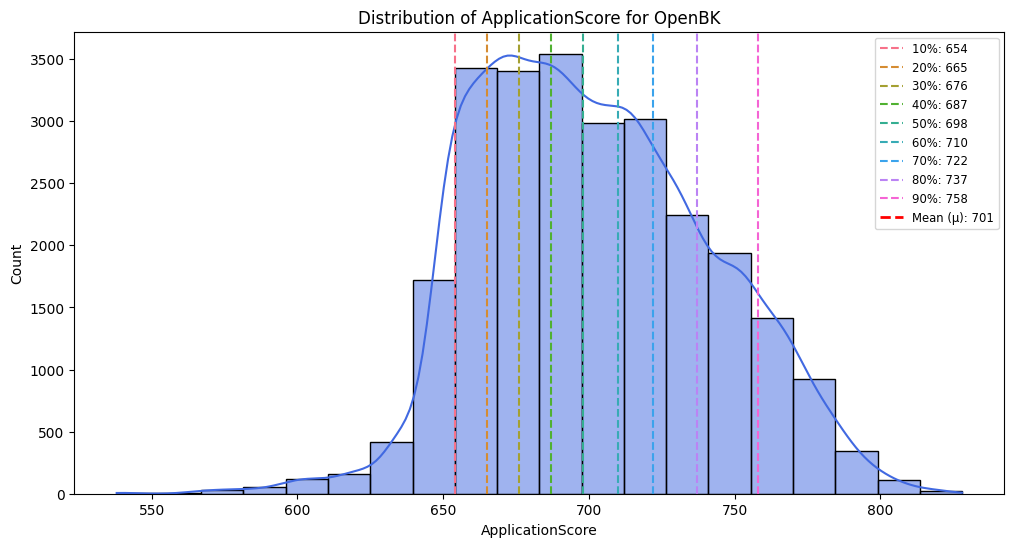

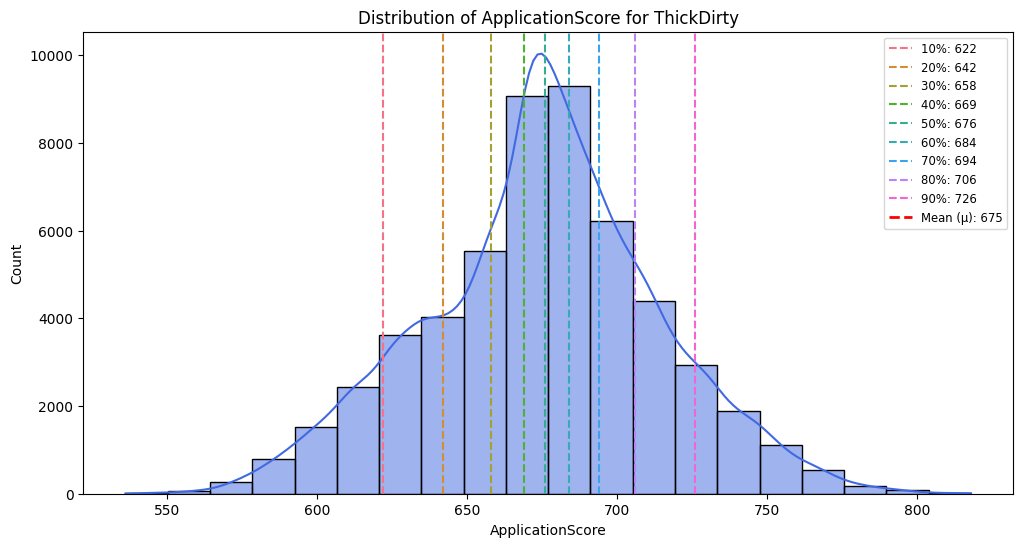

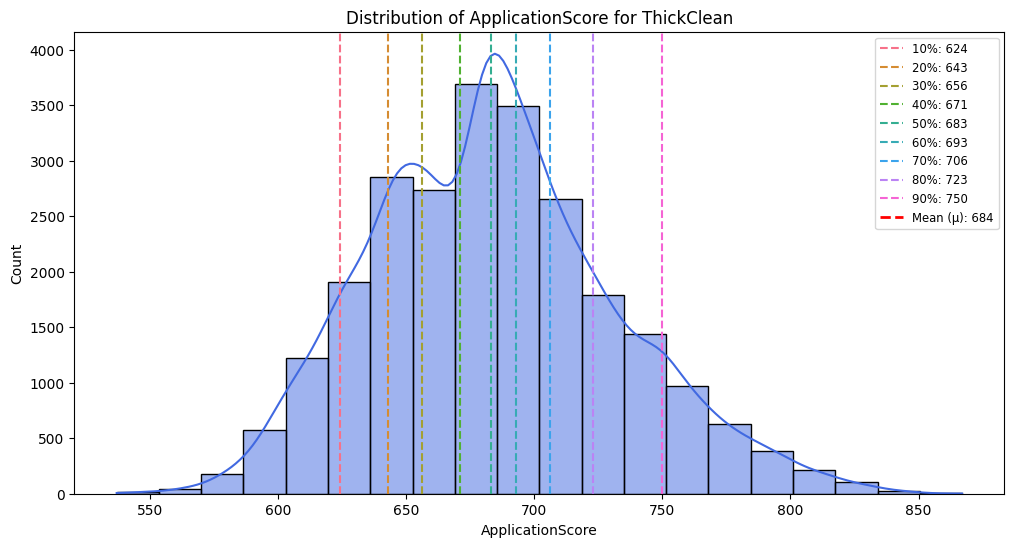

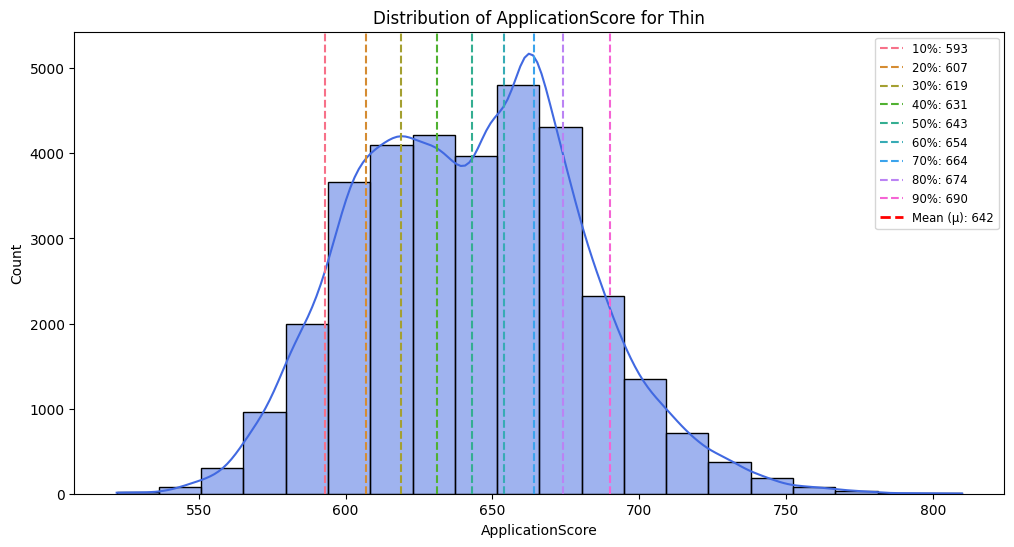

In [49]:
# Call function and export graphs

plot_segmented_distributions10(df3, 'ApplicationScore', 'ApplicationCreditProfileType', output_dir=r'M:/Risk Management/DW/TUX Scorecard/Thresholds/Threshold Testing/BatchFile_Thresholds_20251020/Output_Graphs/20251024/')

In [50]:
def calculate_decile_summary(df, score_col, segment_col):

    # Filter to applicant rows only
    # df = df[df['Applicant_Index'] == 1].copy()
   
    # Define decile labels consistently
    decile_labels = [f"D{i+1} ({i*10}-{(i+1)*10}%)" for i in range(10)]

    # Assign deciles
    df['EQScore_Decile10'] = df.groupby(segment_col)[score_col].transform(
        lambda x: pd.qcut(x, q=10, labels=decile_labels, duplicates='drop')
    )

    # List to store summary data
    summary_data = []
    for segment in df[segment_col].unique():
        segment_data = df[df[segment_col] == segment]
        for decile in decile_labels:  # Reuse same labels
            decile_data = segment_data[segment_data['EQScore_Decile10'] == decile]
            count = decile_data.shape[0]
            avg_score_mod = round(decile_data['ApplicantProb2Def'].mean(), 4) if not decile_data.empty else None
            summary_data.append([segment, decile, count, avg_score_mod])

    # Convert to DataFrame
    summary_df = pd.DataFrame(summary_data, columns=[segment_col, 'Decile', 'Count', 'ApplicantProb2Def'])

    # Pivot tables
    count_table = summary_df.pivot_table(index=segment_col, columns='Decile', values='Count', aggfunc='first')
    avg_score_table = summary_df.pivot_table(index=segment_col, columns='Decile', values='ApplicantProb2Def', aggfunc='first')

    return count_table, avg_score_table


In [51]:
# Function to display the tables with simple formatting
def display_tables(count_table, avg_score_table):
    
    # Print the count table and average score table
    print("Count Table (Applications per Decile):")
    print(count_table.to_string())
    
    # Print the average score table
    print("\nAverage Score Table (Avg Score per Decile):")
    print(avg_score_table.to_string())  


In [52]:
def add_decile_ranges(df, score_col, segment_col):

    # Filter to applicant rows only
    # df = df[df['Applicant_Index'] == 1].copy()
   
    decile_labels = [f"D{i+1} ({i*10}-{(i+1)*10}%)" for i in range(10)]
    ranges = {}

    for segment in df[segment_col].unique():
        segment_data = df[df[segment_col] == segment]
        deciles = segment_data[score_col].quantile([i/10 for i in range(1, 10)]).values
        full_deciles = [segment_data[score_col].min()] + list(deciles) + [segment_data[score_col].max()]

        # Assign ranges
        ranges[segment] = {
            decile_labels[i]: (full_deciles[i], full_deciles[i+1]) for i in range(10)
        }

    return ranges

In [53]:
# Call the function to add ranges
ranges = add_decile_ranges(df3, 'ApplicationScore', 'ApplicationCreditProfileType')

# Print the ranges for each decile
for segment, decile_ranges in ranges.items():
    print(f"\nDecile Ranges for {segment}:")
    for decile, (low, high) in decile_ranges.items():
        print(f"{decile}: {low:.0f} - {high:.0f}")


Decile Ranges for OpenBK:
D1 (0-10%): 538 - 654
D2 (10-20%): 654 - 665
D3 (20-30%): 665 - 676
D4 (30-40%): 676 - 687
D5 (40-50%): 687 - 698
D6 (50-60%): 698 - 710
D7 (60-70%): 710 - 722
D8 (70-80%): 722 - 737
D9 (80-90%): 737 - 758
D10 (90-100%): 758 - 828

Decile Ranges for ThickDirty:
D1 (0-10%): 536 - 622
D2 (10-20%): 622 - 642
D3 (20-30%): 642 - 658
D4 (30-40%): 658 - 669
D5 (40-50%): 669 - 676
D6 (50-60%): 676 - 684
D7 (60-70%): 684 - 694
D8 (70-80%): 694 - 706
D9 (80-90%): 706 - 726
D10 (90-100%): 726 - 818

Decile Ranges for ThickClean:
D1 (0-10%): 537 - 624
D2 (10-20%): 624 - 643
D3 (20-30%): 643 - 656
D4 (30-40%): 656 - 671
D5 (40-50%): 671 - 683
D6 (50-60%): 683 - 693
D7 (60-70%): 693 - 706
D8 (70-80%): 706 - 723
D9 (80-90%): 723 - 750
D10 (90-100%): 750 - 867

Decile Ranges for Thin:
D1 (0-10%): 522 - 593
D2 (10-20%): 593 - 607
D3 (20-30%): 607 - 619
D4 (30-40%): 619 - 631
D5 (40-50%): 631 - 643
D6 (50-60%): 643 - 654
D7 (60-70%): 654 - 664
D8 (70-80%): 664 - 674
D9 (80-90%

In [54]:
# Count table

# Filter to applicant rows only
# df3 = df3[df3['Applicant_Index'] == 1].copy()

# Calculate the decile summaries
count_table, avg_score_table = calculate_decile_summary(df3, 'ApplicationScore', 'ApplicationCreditProfileType')

# Display the tables
display_tables(count_table, avg_score_table)

# Get the decile ranges
ranges = add_decile_ranges(df3, 'ApplicationScore', 'ApplicationCreditProfileType')

# Print the ranges
for segment, decile_ranges in ranges.items():
    print(f"\nDecile Ranges for {segment}:")
    for decile, (low, high) in decile_ranges.items():
        print(f"{decile}: {low:.0f} - {high:.0f}")


Count Table (Applications per Decile):
Decile                        D1 (0-10%)  D10 (90-100%)  D2 (10-20%)  D3 (20-30%)  D4 (30-40%)  D5 (40-50%)  D6 (50-60%)  D7 (60-70%)  D8 (70-80%)  D9 (80-90%)
ApplicationCreditProfileType                                                                                                                                   
OpenBK                              2709           2484         2494         2716         2613         2551         2546         2534         2564         2678
ThickClean                          2558           2435         2580         2376         2494         2693         2408         2505         2412         2494
ThickDirty                          5542           5210         5420         5430         5708         5238         5343         5467         5077         5594
Thin                                3352           3271         3402         3434         3474         3192         3381         3501         3153         3297



In [55]:
# Generate decile ranges table
decile_rows = []
for segment, decile_ranges in ranges.items():
    for decile, (low, high) in decile_ranges.items():
        decile_rows.append({
            'Segment': segment,
            'Decile': decile,
            'Min Score': round(low, 0),
            'Max Score': round(high, 0)
        })
ranges_df = pd.DataFrame(decile_rows)


# Output filename
output_filename = 'M:/Risk Management/DW/TUX Scorecard/Thresholds/Threshold Testing/BatchFile_Thresholds_20251020/20251024_BatchApplication_Thresholds.xlsx'


In [56]:
# Define paths
output_dir = 'M:/Risk Management/DW/TUX Scorecard/Thresholds/Threshold Testing/BatchFile_Thresholds_20251020/'
output_filename = os.path.join(output_dir, '20251024_BatchApplication_Thresholds.xlsx')

# Recompute decile range table
decile_rows = []
for segment, decile_ranges in ranges.items():
    for decile, (low, high) in decile_ranges.items():
        decile_rows.append({
            'Segment': segment,
            'Decile': decile,
            'Min Score': round(low, 0),
            'Max Score': round(high, 0)
        })
ranges_df = pd.DataFrame(decile_rows)

# Write all to Excel 
with pd.ExcelWriter(output_filename, engine='xlsxwriter') as writer:
    df3.to_excel(writer, sheet_name='df_ApplicationThresholds_Data', index=False)
    count_table.to_excel(writer, sheet_name='Decile Threshold Counts')
    avg_score_table.to_excel(writer, sheet_name='Avg Prob2Def')
    ranges_df.to_excel(writer, sheet_name='Decile Threshold Ranges', index=False)

print(f"Workbook saved: {output_filename}")

Workbook saved: M:/Risk Management/DW/TUX Scorecard/Thresholds/Threshold Testing/BatchFile_Thresholds_20251020/20251024_BatchApplication_Thresholds.xlsx
